In [449]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [450]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Compose, Normalize
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch
from PIL import Image
import io

Ustawienie ścieżki do bazy. Na swoim dysku utworzyłem skrót do udostępnionego folderu z bazą.

In [451]:
from pathlib import Path
base_path = Path('/content/drive/MyDrive/projekt-ml')

Pobrane dane.

In [452]:
from datasets import load_from_disk

dataset = load_from_disk(base_path / 'minecraft_dataset_vectors')
ds = dataset.to_pandas()
ds

,image,is_block,type,colors
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...,...,...,...
1513,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1514,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1515,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1516,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [453]:
mask = []
for index, row in ds.iterrows():
    img = Image.open(io.BytesIO(row['image']['bytes']))
    mask.append((img.width == 16) & (img.height == 16))

Maska do usunięcia tekstur o wymiarach innych niż 16x16. Mógłbym zrobić resize na dalszym etapie, ale raczej nie chcemy potem takich rozmazanych tekstur w modelu ...

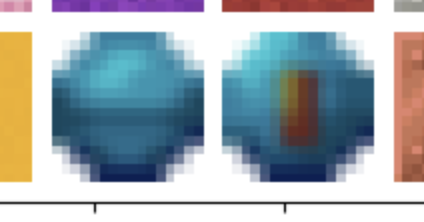

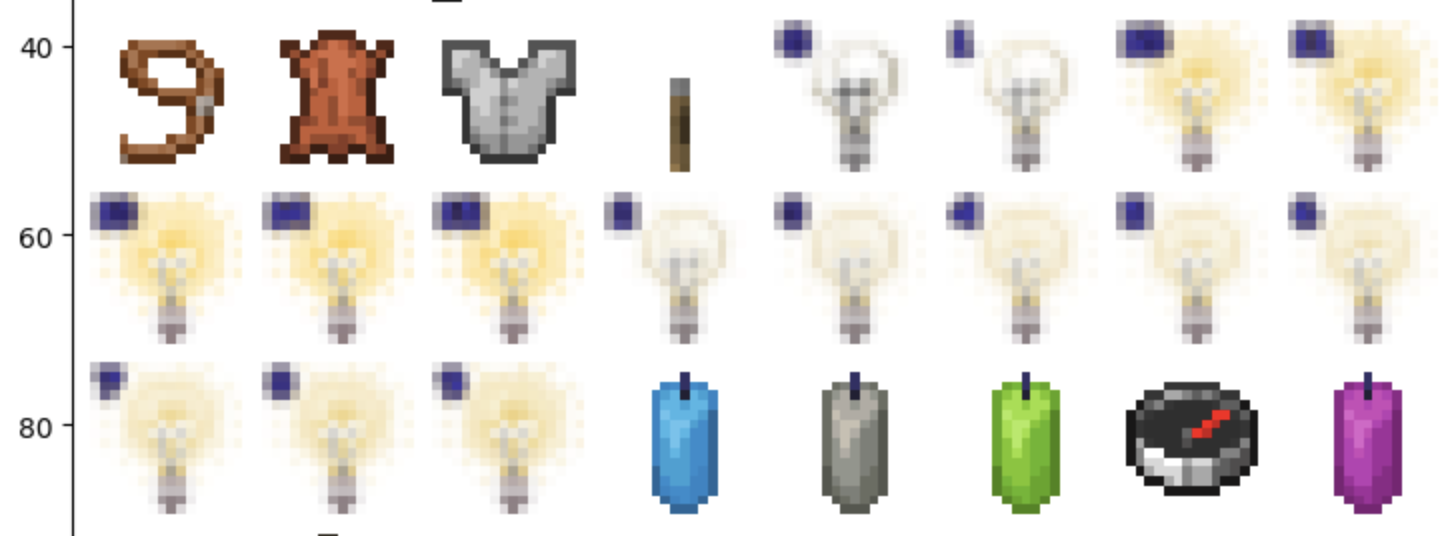

Zastosowanie maski. Zniknęło w sumie 19 wierszy.

In [454]:
ds = ds[mask]
ds

,image,is_block,type,colors
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...,...,...,...
1513,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1514,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1515,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1516,"{'bytes': b""\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


Custowy dataset dla danych z pliku.

In [455]:
class MinecraftDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = Compose([
            ToTensor()
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # get image
        img_bytes = self.dataframe.iloc[idx]['image']['bytes']
        img = Image.open(io.BytesIO(img_bytes)).convert("RGBA")
        img_tensor = self.transform(img)
        # get other columns
        is_block = self.dataframe.iloc[idx]['is_block']
        type_ = self.dataframe.iloc[idx]['type']
        colors = self.dataframe.iloc[idx]['colors']

        return img_tensor, is_block, type_, colors

Utworzenie DataLoadera dla customowego datasetu.

In [456]:
minecraft_dataset = MinecraftDataset(ds)
train_loader = DataLoader(minecraft_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

---
Podgląd zawartości pojedynczego batcha z istniejącego DataLoadera.

In [457]:
dataiter = iter(train_loader)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [458]:
imgs_batch = next(dataiter)[0] # get new batch (with only img_tensors)

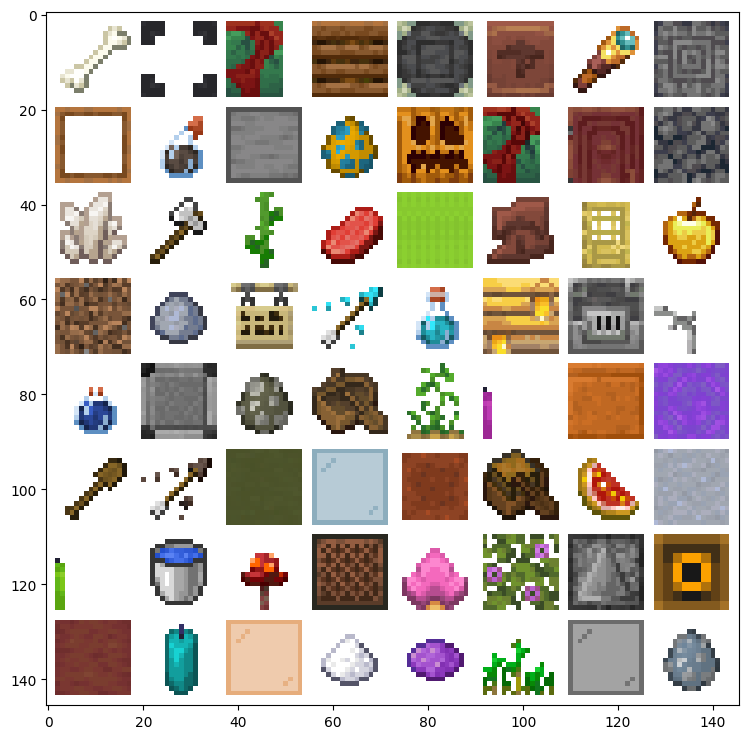

In [459]:
plt.figure(figsize = (9,9))
out = vutils.make_grid(imgs_batch, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))